In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
class NHL_Period_Data:
    def __init__(self, dataFile="data/periodStats.txt"):
        self.data_x, self.data_y = self.__parseData__(dataFile)
        self.train_x = None
        self.train_p1_x = None
        self.train_p2_x = None
        self.train_p3_x = None
        self.train_p4_x = None
        self.train_y = None
        self.train_p1_y = None
        self.train_p2_y = None
        self.train_p3_y = None
        self.train_p4_y = None
        self.test_x = None
        self.test_p1_x = None
        self.test_p2_x = None
        self.test_p3_x = None
        self.test_p4_x = None
        self.test_y = None
        self.test_p1_y = None
        self.test_p2_y = None
        self.test_p3_y = None
        self.test_p4_y = None
        
    def __parseData__(self, dataFile):
        #data = np.genfromtxt(dataFile, delimiter=",", dtype=[int,int,int,int,int,int,int,int,int,
        #                                                     int,int,int,int,int,int,int,int,int,
        #                                                     'float64','float64',int], skip_header=1)
        data = np.genfromtxt(dataFile, delimiter=",", dtype='float64', skip_header=1)
        return data[...,0:-1],data[...,-1].astype(int)
    
    def transformData(self, encoder="StandardScaler",cols=None):
        if cols is None:
            cols = list(range(len(self.data_x[0])))
        col_tr = ColumnTransformer([(encoder, getattr(preprocessing,encoder)(),cols)])
        col_tr.fit(self.data_x, self.data_y)
        self.data_x = col_tr.transform(self.data_x)
    
    def transformPeriodData(self, encoder="StandardScaler", cols=None):
        if cols is None:
            cols = list(range(len(self.p1_data_x[0])))

        i = 1
        for data_x, data_y in zip([self.p1_data_x,self.p2_data_x,self.p3_data_x,self.pOT_data_x],
                                  [self.p1_data_y,self.p2_data_y,self.p3_data_y,self.pOT_data_y]):            
            col_tr = ColumnTransformer([(encoder, getattr(preprocessing,encoder)(),cols)])
            col_tr.fit(data_x, data_y)
            if i == 1:
                self.train_p1_x = col_tr.transform(self.train_p1_x)
                self.test_p1_x = col_tr.transform(self.test_p1_x)
            if i == 2:
                self.train_p2_x = col_tr.transform(self.train_p2_x)
                self.test_p2_x = col_tr.transform(self.test_p2_x)
            if i == 3:
                self.train_p3_x = col_tr.transform(self.train_p3_x)
                self.test_p3_x = col_tr.transform(self.test_p3_x)
            if i == 4:
                self.train_p4_x = col_tr.transform(self.train_p4_x)
                self.test_p4_x = col_tr.transform(self.test_p4_x)
            i+=1
        
    def trainTestSplit(self, split=0.2, period=None):
        self.train_p1_x,self.test_p1_x,self.train_p1_y,self.test_p1_y = \
            train_test_split(self.p1_data_x, self.p1_data_y, test_size=split)
        
        self.train_p2_x,self.test_p2_x,self.train_p2_y,self.test_p2_y = \
            train_test_split(self.p2_data_x, self.p2_data_y, test_size=split)

        self.train_p3_x,self.test_p3_x,self.train_p3_y,self.test_p3_y = \
            train_test_split(self.p3_data_x, self.p3_data_y, test_size=split)
        
        self.train_p4_x,self.test_p4_x,self.train_p4_y,self.test_p4_y = \
            train_test_split(self.pOT_data_x, self.pOT_data_y, test_size=split)
        
        self.train_x,self.test_x,self.train_y,self.test_y = \
            train_test_split(self.data_x[...,1:], self.data_y, test_size=split)
        
    def combineHomeAwayFeatures(self):
        home_away = [[3,2],[5,4],[7,6],[9,8],[11,10],[13,12],[15,14],[17,16],[18,19]]
        combined = np.zeros((len(self.data_x),11))
        combined[...,0] = self.data_x[...,0]
        combined[...,1] = self.data_x[...,1]

        pos = 2
        for i in home_away:
            combined[...,pos] = self.data_x[...,i[0]] - self.data_x[...,i[1]]
            pos += 1
        self.data_comb_x = combined
        
    def selectKBest(self, k=10):
        selector = SelectKBest(k=k).fit(self.train_x, self.train_y)
        self.train_x = selector.transform(self.train_x)
        self.test_x = selector.transform(self.test_x)
        
    def chooseColumns(self, cols):
        self.train_xc = self.train_x[...,cols]
        self.train_p1_xc = self.train_p1_x[...,cols]
        self.train_p2_xc = self.train_p2_x[...,cols]
        self.train_p3_xc = self.train_p3_x[...,cols]
        self.train_p4_xc = self.train_p4_x[...,cols]
        self.test_p1_xc = self.test_p1_x[...,cols]
        self.test_p2_xc = self.test_p2_x[...,cols]
        self.test_p3_xc = self.test_p3_x[...,cols]
        self.test_p4_xc = self.test_p4_x[...,cols]
        
    def binScores(self, max_bin=4, min_bin=-4):
        if self.train_y is not None:
            self.train_y = np.where(self.train_y > max_bin, max_bin, self.train_y)
            self.train_y = np.where(self.train_y < min_bin, min_bin, self.train_y)
            self.test_y = np.where(self.test_y > max_bin, max_bin, self.test_y)
            self.test_y = np.where(self.test_y < min_bin, min_bin, self.test_y)
        else:
            self.data_y = np.where(self.data_y > max_bin, max_bin, self.data_y)
            self.data_y = np.where(self.data_y < min_bin, min_bin, self.data_y)
    
    def splitByPeriod(self, comb=False):
        if comb:
            data_x = self.data_comb_x
        else:
            data_x = self.data_x
        p1x = []
        p2x = []
        p3x = []
        pox = []
        p1y = []
        p2y = []
        p3y = []
        poy = []
        for i,x in enumerate(data_x):
            p = x[0].astype(int)%10
            y = self.data_y[i]
            if p == 1:
                p1x.append(x[1:])
                p1y.append(y)
            elif p == 2:
                p2x.append(x[1:])
                p2y.append(y)
            elif p == 3:
                p3x.append(x[1:])
                p3y.append(y)
            else:
                pox.append(x[1:])
                poy.append(y)
                
        self.p1_data_x = np.array(p1x)
        self.p1_data_y = np.array(p1y)
        self.p2_data_x = np.array(p2x)
        self.p2_data_y = np.array(p2y)
        self.p3_data_x = np.array(p3x)
        self.p3_data_y = np.array(p3y)
        self.pOT_data_x = np.array(pox)
        self.pOT_data_y = np.array(poy)


In [3]:
testD = NHL_Period_Data()
testD.splitByPeriod()
print(testD.p1_data_x[11243])
print(testD.p2_data_x[11243])
print(testD.p3_data_x[11243])
print(len(testD.pOT_data_x))
print(testD.pOT_data_x[3856])

[ 0.  9.  2.  7. 11.  0.  5. 14. 11.  2.  1.  1.  0.  2. 12.  2.  5.]
[-2.  6.  5. 10.  7.  4.  7. 13. 10.  3.  1.  0.  0.  6. 11.  3.  1.]
[-2.  6.  0.  8.  8.  3.  1.  9.  7.  0.  6.  0.  0.  8.  9.  3.  0.]
3857
[0. 0. 2. 0. 1. 0. 0. 5. 0. 2. 0. 0. 0. 3. 0. 2. 0.]


In [4]:
data = NHL_Period_Data()
print(data.data_x[0])
data.transformData("MinMaxScaler")
print(data.data_x[0])
data.trainTestSplit()

[2.01002e+10 0.00000e+00 7.00000e+00 6.00000e+00 9.00000e+00 5.00000e+00
 4.00000e+00 6.00000e+00 1.50000e+01 1.10000e+01 3.00000e+00 4.00000e+00
 2.00000e+00 0.00000e+00 6.00000e+00 1.00000e+01 4.00000e+00 3.00000e+00]
[0.         0.46666667 0.31818182 0.33333333 0.40909091 0.2173913
 0.26666667 0.35294118 0.48387097 0.34375    0.2        0.21052632
 0.08333333 0.         0.2        0.35714286 0.30769231 0.21428571]


AttributeError: 'NHL_Period_Data' object has no attribute 'p1_data_x'

## KNN Classifier

In [5]:
from sklearn.neighbors import KNeighborsClassifier

params = {'n_neighbors':list(range(3,15,2)), 'weights':['uniform','distance'],
          'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size':list(range(10,40)),
          'p':[1,2], 'n_jobs':[-1]}
#knn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto', leaf_size=30,
#                           p=2, metric='minkowski', metric_params=None, n_jobs=-1)
knn = KNeighborsClassifier()
model = GridSearchCV(knn, params)
model.fit(data.train_x, data.train_y)
pred_vals = model.predict(data.test_x)
print("Predicted values: " + str(pred_vals[0:10]))
print("Actual Values:    " + str(data.test_y[0:10]))
acc = accuracy_score(data.test_y, pred_vals)
print("Validation accuracy: " + str(acc))

TypeError: Expected sequence or array-like, got <class 'NoneType'>

In [6]:
stand_data = NHL_Period_Data()
stand_data.transformData()
stand_data.trainTestSplit()
#stand_data.selectKBest(15)

AttributeError: 'NHL_Period_Data' object has no attribute 'p1_data_x'

In [7]:
#print(model.best_params_)
# {'algorithm': 'auto', 'leaf_size': 20, 'n_jobs': -1, 'n_neighbors': 13, 'p': 2, 'weights': 'distance'}

best_knn = KNeighborsClassifier(n_neighbors=13, weights='distance', algorithm='auto', leaf_size=8,
                                p=2, n_jobs=-1)
best_knn.fit(stand_data.train_x, stand_data.train_y)
best_pred = best_knn.predict(stand_data.test_x)
b_acc = accuracy_score(stand_data.test_y, best_pred)
print("Acc for leaf_size 8: " + str(b_acc))

ValueError: y cannot be None

In [8]:
for i in reversed(range(1,17)):
    stand_data.selectKBest(i)
    best_knn.fit(stand_data.train_x, stand_data.train_y)
    best_pred = best_knn.predict(stand_data.test_x)
    b_acc = accuracy_score(stand_data.test_y, best_pred)
    print("Acc for " + str(i) + " features: " + str(b_acc))

ValueError: y cannot be None

## Random Forest Classifier

In [9]:
stand_data = NHL_Period_Data()
stand_data.transformData("MinMaxScaler")
stand_data.trainTestSplit()
stand_data.binScores()

AttributeError: 'NHL_Period_Data' object has no attribute 'p1_data_x'

In [10]:
rf_class = RandomForestClassifier(n_estimators=71,criterion='gini',max_depth=16,min_samples_split=2,
                                 min_samples_leaf=1,min_weight_fraction_leaf=0.0,
                                 max_features='auto',max_leaf_nodes=61,min_impurity_decrease=0.0)

rf_class.fit(stand_data.train_x, stand_data.train_y)
rf_pred = rf_class.predict(stand_data.test_x)
rf_acc = accuracy_score(stand_data.test_y, rf_pred)
print("Acc for random forest: " + str(rf_acc))

ValueError: Expected 2D array, got scalar array instead:
array=nan.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

TypeError: '<' not supported between instances of 'NoneType' and 'float'

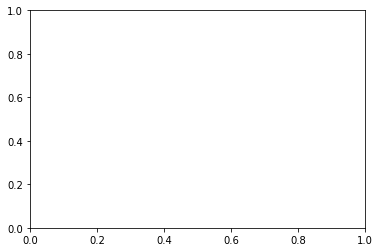

In [11]:
plt.hist(stand_data.train_y)
plt.show()
print(Counter(stand_data.train_y))

In [12]:
rf_grid = RandomForestClassifier()
rf_params = {'n_estimators':[10,35,50,70,90,150],'max_depth':[None,1,3,8,15,25], 
             'min_samples_split':[2,5,10]}
rf_grid_search = GridSearchCV(rf_grid,rf_params)
rf_grid_search.fit(stand_data.train_x, stand_data.train_y)
rf_grid_pred = rf_grid_search.predict(stand_data.test_x)
rf_grid_acc = accuracy_score(stand_data.test_y, rf_grid_pred)
print("Best Fit model acc for grid search: " + str(rf_grid_acc))

TypeError: Expected sequence or array-like, got <class 'NoneType'>

In [13]:
#Best Params: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 90}
#Best Params: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 150}
#Best Fit model acc for grid search: 0.3635275339185954
print("Best Params: " + str(rf_grid_search.best_params_))

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [14]:
rf_best = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=150)
rf_best.fit(stand_data.train_x, stand_data.train_y)
rf_best_pred = rf_best.predict(stand_data.test_x)
rf_best_acc = accuracy_score(stand_data.test_y, rf_best_pred)
print("Accuracy: " + str(rf_best_acc))

ValueError: Expected 2D array, got scalar array instead:
array=nan.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## Random Forest by Period

In [15]:
periodData = NHL_Period_Data()
periodData.binScores(max_bin=1, min_bin=-1)
periodData.splitByPeriod()
periodData.trainTestSplit(split=0.2, period=1)
periodData.transformPeriodData("MinMaxScaler")

Accuracy: 0.3917296576256114


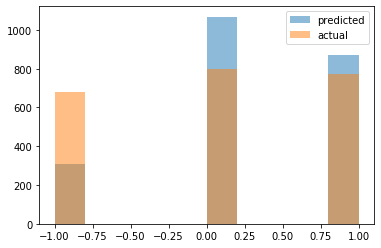

In [16]:
rf_period1 = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=150)
rf_period1.fit(periodData.train_p1_x, periodData.train_p1_y)
rf_p1_pred = rf_period1.predict(periodData.test_p1_x)
rf_p1_acc = accuracy_score(periodData.test_p1_y, rf_p1_pred)
print("Accuracy: " + str(rf_p1_acc))

plt.hist(rf_p1_pred, alpha=0.5, label='predicted')
plt.hist(periodData.test_p1_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()

Accuracy: 0.38683859493108047


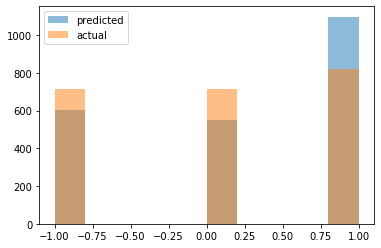

In [17]:
#periodData.trainTestSplit(split=0.2, period=2)
rf_period2 = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=150)
rf_period2.fit(periodData.train_p2_x, periodData.train_p2_y)
rf_p2_pred = rf_period2.predict(periodData.test_p2_x)
rf_p2_acc = accuracy_score(periodData.test_p2_y, rf_p2_pred)

print("Accuracy: " + str(rf_p2_acc))
plt.hist(rf_p2_pred, alpha=0.5, label='predicted')
plt.hist(periodData.test_p2_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()

Accuracy: 0.4468652734548688


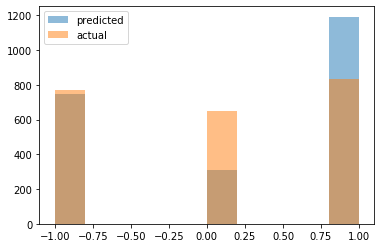

In [18]:
#periodData.trainTestSplit(split=0.2, period=3)
rf_period3 = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=150)
rf_period3.fit(periodData.train_p3_x, periodData.train_p3_y)
rf_p3_pred = rf_period3.predict(periodData.test_p3_x)
rf_p3_acc = accuracy_score(periodData.test_p3_y, rf_p3_pred)

print("Accuracy: " + str(rf_p3_acc))
plt.hist(rf_p3_pred, alpha=0.5, label='predicted')
plt.hist(periodData.test_p3_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()

OT samples: 30071
Accuracy: 0.7603626943005182


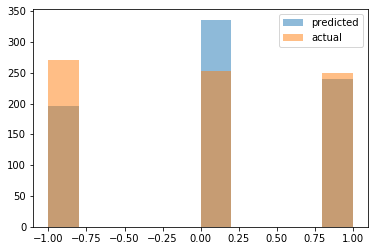

In [19]:
#periodData.trainTestSplit(split=0.2, period=4)
print("OT samples: " + str(len(periodData.train_x)))
rf_periodOT = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=150)
rf_periodOT.fit(periodData.train_p4_x, periodData.train_p4_y)
rf_pOT_pred = rf_periodOT.predict(periodData.test_p4_x)
rf_pOT_acc = accuracy_score(periodData.test_p4_y, rf_pOT_pred)

print("Accuracy: " + str(rf_pOT_acc))
plt.hist(rf_pOT_pred, alpha=0.5, label='predicted')
plt.hist(periodData.test_p4_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()

## Boosting classifiers

In [20]:
boostData = NHL_Period_Data()
boostData.binScores(max_bin=1, min_bin=-1)
boostData.splitByPeriod()
boostData.trainTestSplit(split=0.2)
boostData.transformData("MinMaxScaler")
print(boostData.train_x.shape)
print(boostData.train_x[0])

(30071, 17)
[ 0.  6.  4. 10. 11. 12.  6.  7.  7.  3.  2.  2.  0. 10.  9.  4.  1.]


Gradient Boost Acc: 0.4486565575951051


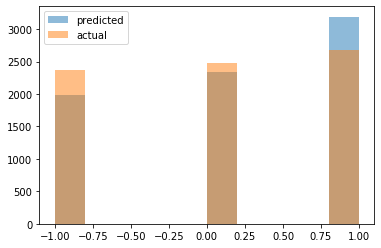

In [21]:
gBoost = GradientBoostingClassifier()
gBoost.fit(boostData.train_x, boostData.train_y)
gb_pred = gBoost.predict(boostData.test_x)
gb_acc = accuracy_score(boostData.test_y, gb_pred)
print("Gradient Boost Acc: " + str(gb_acc))
plt.hist(gb_pred, alpha=0.5, label='predicted')
plt.hist(boostData.test_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()

In [22]:
gBoost = GradientBoostingClassifier()
params = {'n_estimators':[50,100,150,200,300],'learning_rate':[0.1,0.3,0.6,1,1.342],
          'max_depth':[1,3,8], 'max_leaf_nodes':[10,50,75,100]}
gb_grid = GridSearchCV(estimator=gBoost, param_grid=params, n_jobs=-1, cv=5)
gb_grid.fit(boostData.train_x, boostData.train_y)
gb_pred = gb_grid.predict(boostData.test_x)
gb_acc = accuracy_score(boostData.test_y, gb_pred)
print("Best Params: " + str(gb_grid.best_params_))
print("Accuracy: " + str(gb_acc))
plt.hist(gb_pred, alpha=0.5, label='predicted')
plt.hist(boostData.test_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()

KeyboardInterrupt: 

0 = period initial goal differential <br></br>
1 = blocked shots away<br></br>
2 = blocked shots home<br></br>
3 = faceoff away<br></br>
4 = faceoff home<br></br>
5 = giveaway away<br></br>
6 = giveaway home<br></br>
7 = hit away<br></br>
8 = hit home <br></br>
9 = missed shot away <br></br>
10 = missed shot home<br></br>
11 = penalty away<br></br>
12 = penalty home <br></br>
13 = shot away<br></br>
14 = shot home<br></br>
15 = takeaway away<br></br>
16 = takeaway home<br></br>
17 = Av Shift Length Home <br></br>
18 = Av Shift Length Away <br></br>


In [23]:
select_data = NHL_Period_Data()
select_data.binScores(max_bin=1, min_bin=-1)
select_data.splitByPeriod()
select_data.trainTestSplit(split=0.2,period=i)
#select_data.transformPeriodData(encoder="MinMaxScaler", cols=None)
select_data.transformPeriodData(encoder="MinMaxScaler", cols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

Period 2
Gradient Boost Acc: 0.3863939528679413


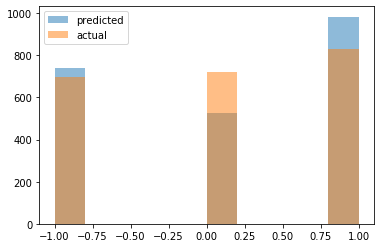

Period 3
Gradient Boost Acc: 0.4624277456647399


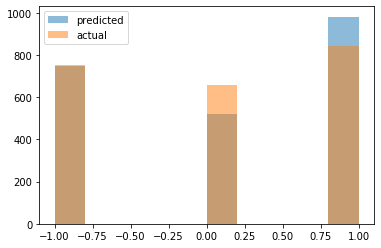

In [25]:
# Gradient Boost Params:
# Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 50, 'n_estimators': 200}
# Accuracy: 0.4507847831870178
x_train = {1:"train_p1_x", 2:"train_p2_x", 3:"train_p3_x", 4:"train_p4_x"}
y_train = {1:"train_p1_y", 2:"train_p2_y", 3:"train_p3_y", 4:"train_p4_y"}
x_test = {1:"test_p1_x", 2:"test_p2_x", 3:"test_p3_x", 4:"test_p4_x"}
y_test = {1:"test_p1_y", 2:"test_p2_y", 3:"test_p3_y", 4:"test_p4_y"}
for i in range(2,4):
    print("Period " + str(i))
    gBoost_select_f = GradientBoostingClassifier(learning_rate=.1, max_depth=3, max_leaf_nodes=50,
                                                 n_estimators=200)
    gBoost_select_f.fit(getattr(select_data,x_train[i]), getattr(select_data,y_train[i]))
    gb_sf_pred = gBoost_select_f.predict(getattr(select_data,x_test[i]))
    gb_sf_acc = accuracy_score(getattr(select_data,y_test[i]), gb_sf_pred)
    print("Gradient Boost Acc: " + str(gb_sf_acc))
    plt.hist(gb_sf_pred, alpha=0.5, label='predicted')
    plt.hist(getattr(select_data,y_test[i]), alpha=0.5, label='actual')
    plt.legend(loc='best')
    plt.show()

In [26]:
select_data = NHL_Period_Data()
select_data.binScores(max_bin=1, min_bin=-1)
select_data.splitByPeriod()
select_data.trainTestSplit(split=0.2,period=i)
#select_data.transformPeriodData(encoder="MinMaxScaler", cols=None)
select_data.transformPeriodData(encoder="MinMaxScaler", cols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

Period 1
Gradient Boost Acc: 0.3863939528679413


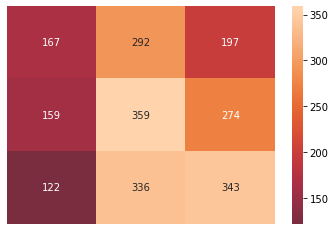

Period 2
Gradient Boost Acc: 0.3917296576256114


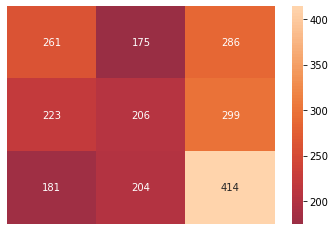

Period 3
Gradient Boost Acc: 0.4655402401067141


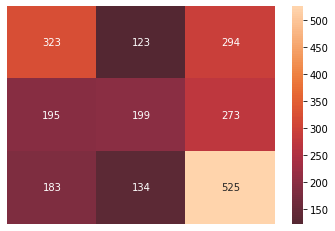

Period 4
Gradient Boost Acc: 0.75


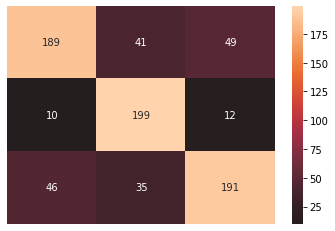

In [37]:
for i in [1,2,3,4]:
    print("Period " + str(i))
    gBoost_select_f = GradientBoostingClassifier(learning_rate=.1, max_depth=3, max_leaf_nodes=50,
                                                 n_estimators=200)
    gBoost_select_f.fit(getattr(select_data,x_train[i]), getattr(select_data,y_train[i]))
    gb_sf_pred = gBoost_select_f.predict(getattr(select_data,x_test[i]))
    gb_sf_acc = accuracy_score(getattr(select_data,y_test[i]), gb_sf_pred)
    print("Gradient Boost Acc: " + str(gb_sf_acc))
    
    """plt.hist(gb_sf_pred, alpha=0.5, label='predicted')
    plt.hist(getattr(select_data,y_test[i]), alpha=0.5, label='actual')
    plt.legend(loc='best')
    plt.show()"""
    
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    cm = confusion_matrix(getattr(select_data,y_test[i]), gb_sf_pred)
    
    import seaborn as sns
    sns.heatmap(cm, center=True,annot=True, fmt="d",xticklabels=False, yticklabels=False)
    plt.show()
    
    

Period 1
Gradient Boost Acc: 0.3743886171631836


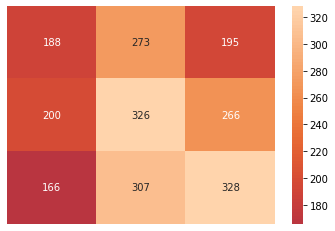

Period 2
Gradient Boost Acc: 0.37705646954201866


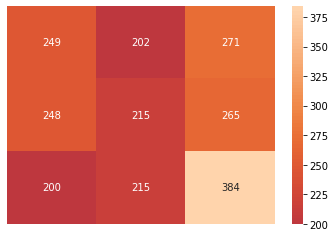

Period 3
Gradient Boost Acc: 0.45264562027567806


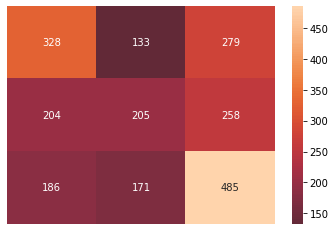

Period 4
Gradient Boost Acc: 0.7344559585492227


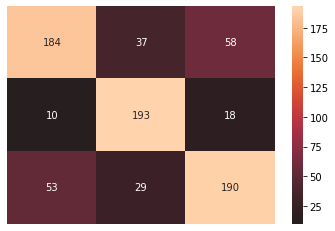

In [36]:
for i in [1,2,3,4]:
    print("Period " + str(i))
    gBoost_select_f = GradientBoostingClassifier(loss="deviance",learning_rate=.1, max_depth=4, max_leaf_nodes=50,
                                                 n_estimators=400,ccp_alpha=.000000001)
    gBoost_select_f.fit(getattr(select_data,x_train[i]), getattr(select_data,y_train[i]))
    gb_sf_pred = gBoost_select_f.predict(getattr(select_data,x_test[i]))
    gb_sf_acc = accuracy_score(getattr(select_data,y_test[i]), gb_sf_pred)
    print("Gradient Boost Acc: " + str(gb_sf_acc))
    
    """
    plt.hist(gb_sf_pred, alpha=0.5, label='predicted')
    plt.hist(getattr(select_data,y_test[i]), alpha=0.5, label='actual')
    plt.legend(loc='best')
    plt.show()
    """
    
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    cm = confusion_matrix(getattr(select_data,y_test[i]), gb_sf_pred)
    
    import seaborn as sns
    sns.heatmap(cm, center=True,annot=True, fmt="d",xticklabels=False, yticklabels=False)
    plt.show()


In [ ]:
select_data = NHL_Period_Data()
select_data.binScores(max_bin=1, min_bin=-1)
select_data.splitByPeriod()
p = 4
select_data.trainTestSplit(split=0.2,period=p)
#select_data.transformPeriodData(encoder="MinMaxScaler", cols=None)
select_data.transformPeriodData(encoder="MinMaxScaler", cols=[3,4,7,8,9,10,11,12,13,14,15,16])

av_acc = 0
for i in range(10):
    gBoost_select_f = GradientBoostingClassifier(learning_rate=.1, max_depth=3, max_leaf_nodes=50,
                                             n_estimators=200)
    gBoost_select_f.fit(getattr(select_data,x_train[p]), getattr(select_data,y_train[p]))
    gb_sf_pred = gBoost_select_f.predict(getattr(select_data,x_test[p]))
    av_acc += accuracy_score(getattr(select_data,y_test[p]), gb_sf_pred)
gb_sf_acc = av_acc/10
print("Gradient Boost Acc: " + str(gb_sf_acc))
plt.hist(gb_sf_pred, alpha=0.5, label='predicted')
plt.hist(getattr(select_data,y_test[p]), alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()

In [ ]:
shiftData = NHL_Period_Data()
shiftData.binScores(max_bin=1, min_bin=-1)
shiftData.splitByPeriod()
shiftData.trainTestSplit(split=0.2)
shiftData.transformPeriodData(encoder="MinMaxScaler", cols=None)

for i in range(1,5):
    gBoost_shift = GradientBoostingClassifier(learning_rate=.1, max_depth=3, max_leaf_nodes=50,
                                             n_estimators=200)
    gBoost_shift.fit(getattr(shiftData,x_train[i]), getattr(shiftData,y_train[i]))
    gb_shift_pred = gBoost_shift.predict(getattr(shiftData,x_test[i]))
    shift_acc = accuracy_score(getattr(shiftData,y_test[i]), gb_shift_pred)
    print("Period: " + str(i))
    print("Shift Data Acc: " + str(shift_acc))
    plt.hist(gb_shift_pred, alpha=0.5, label='predicted')
    plt.hist(getattr(shiftData,y_test[i]), alpha=0.5, label='actual')
    plt.legend(loc='best')
    plt.show()

In [ ]:
shiftcolData = NHL_Period_Data()
shiftcolData.binScores(max_bin=1, min_bin=-1)
shiftcolData.splitByPeriod()
shiftcolData.trainTestSplit(split=0.2)
shiftcolData.transformPeriodData(encoder="MinMaxScaler")

In [ ]:
x_train = {1:"train_p1_xc", 2:"train_p2_xc", 3:"train_p3_xc", 4:"train_p4_xc"}
y_train = {1:"train_p1_y", 2:"train_p2_y", 3:"train_p3_y", 4:"train_p4_y"}
x_test = {1:"test_p1_xc", 2:"test_p2_xc", 3:"test_p3_xc", 4:"test_p4_xc"}
y_test = {1:"test_p1_y", 2:"test_p2_y", 3:"test_p3_y", 4:"test_p4_y"}

for p in range(1,5):
    col_pairs = [[0],[1,2],[3,4],[5,6],[7,8],[9,10],[11,12],[13,14],[15,16],[17,18]]
    cols = []
    best_acc = 0
    print("Finding Features for Period " + str(p))
    for s in range(len(col_pairs)):
        max_acc = 0
        max_cols = []
        for t in col_pairs:
            tmp2_cols = []
            for m in cols:
                tmp2_cols.append(m)
            for k in t:
                tmp2_cols.append(k)
            print("Features: " + str(tmp2_cols))
            shiftcolData.chooseColumns(tmp2_cols)
            av_col_acc = 0
            for i in range(5):
                g_col = GradientBoostingClassifier(learning_rate=.1, max_depth=3, max_leaf_nodes=50,
                                                   n_estimators=200)
                g_col.fit(getattr(shiftcolData,x_train[p]), getattr(shiftcolData,y_train[p]))
                g_col_pred = g_col.predict(getattr(shiftcolData,x_test[p]))
                av_col_acc += accuracy_score(getattr(shiftcolData,y_test[p]), g_col_pred)
            col_acc = av_col_acc/5
            if col_acc > max_acc:
                max_acc = col_acc
                max_cols = t
            print("Column Accuracy: " + str(col_acc))
            plt.hist(g_col_pred, alpha=0.5, label='predicted')
            plt.hist(getattr(shiftcolData,y_test[p]), alpha=0.5, label='actual')
            plt.legend(loc='best')
            plt.show()
        # add max cols
        if best_acc >= max_acc:
            print("Adding " + str(max_cols) + " showed no improvement, stopping...")
            print("Best Columns found: " + str(cols))
            break
        
        for k in max_cols:
            cols.append(k)
        col_pairs.remove(max_cols)
        print("~~~ Choosing Max Cols: " + str(max_cols))
        print("~~~ Max Accuracy: " + str(max_acc))
        print("Remaining Columns: " + str(col_pairs))
        best_acc = max_acc
    print("For Period " + str(p) + " Best Columns found: " + str(cols) + " With accuracy: " + str(best_acc))

In [ ]:
combData = NHL_Period_Data()
combData.binScores(max_bin=1, min_bin=-1)
combData.combineHomeAwayFeatures()
combData.splitByPeriod(comb=True)
combData.trainTestSplit(split=0.2)
#combData.transformPeriodData(encoder="MinMaxScaler")
print(combData.train_p2_x[1])
print(combData.train_p1_x.shape)

In [ ]:
"""combClass = GradientBoostingClassifier(learning_rate=.1, max_depth=3, max_leaf_nodes=50,
                                       n_estimators=200)
combClass.fit(combData.train_p3_x, combData.train_p3_y)
gb_shift_pred = combClass.predict(combData.test_p3_x)
shift_acc = accuracy_score(combData.test_p3_y, gb_shift_pred)
print("Period: " + str(i))
print("Shift Data Acc: " + str(shift_acc))
plt.hist(gb_shift_pred, alpha=0.5, label='predicted')
plt.hist(combData.test_p3_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()"""

x_train = {1:"train_p1_xc", 2:"train_p2_xc", 3:"train_p3_xc", 4:"train_p4_xc"}
y_train = {1:"train_p1_y", 2:"train_p2_y", 3:"train_p3_y", 4:"train_p4_y"}
x_test = {1:"test_p1_xc", 2:"test_p2_xc", 3:"test_p3_xc", 4:"test_p4_xc"}
y_test = {1:"test_p1_y", 2:"test_p2_y", 3:"test_p3_y", 4:"test_p4_y"}

for p in range(1,5):
    col_pairs = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
    cols = []
    best_acc = 0
    print("Finding Features for Period " + str(p))
    for s in range(len(col_pairs)):
        max_acc = 0
        max_cols = []
        for t in col_pairs:
            tmp2_cols = []
            for m in cols:
                tmp2_cols.append(m)
            for k in t:
                tmp2_cols.append(k)
            print("Features: " + str(tmp2_cols))
            combData.chooseColumns(tmp2_cols)
            av_col_acc = 0
            for i in range(5):
                g_col = GradientBoostingClassifier(learning_rate=.1, max_depth=3, max_leaf_nodes=50,
                                                   n_estimators=200)
                g_col.fit(getattr(combData,x_train[p]), getattr(combData,y_train[p]))
                g_col_pred = g_col.predict(getattr(combData,x_test[p]))
                av_col_acc += accuracy_score(getattr(combData,y_test[p]), g_col_pred)
            col_acc = av_col_acc/5
            if col_acc > max_acc:
                max_acc = col_acc
                max_cols = t
            print("Column Accuracy: " + str(col_acc))
            plt.hist(g_col_pred, alpha=0.5, label='predicted')
            plt.hist(getattr(combData,y_test[p]), alpha=0.5, label='actual')
            plt.legend(loc='best')
            plt.show()
        # add max cols
        if best_acc >= max_acc:
            print("Adding " + str(max_cols) + " showed no improvement, stopping...")
            print("Best Columns found: " + str(cols))
            break
        
        for k in max_cols:
            cols.append(k)
        col_pairs.remove(max_cols)
        print("~~~ Choosing Max Cols: " + str(max_cols))
        print("~~~ Max Accuracy: " + str(max_acc))
        print("Remaining Columns: " + str(col_pairs))
        best_acc = max_acc
    print("For Period " + str(p) + " Best Columns found: " + str(cols) + " With accuracy: " + str(best_acc))